In [ ]:
# -*- coding: utf-8 -*-
#Vehicle license plate image processing system
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

# make tracks
SUPPORTED_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')
INPUT_FOLDER = "/kaggle/input/car-plate-detection/images"
OUTPUT_FOLDER = "/kaggle/working/processed_results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [ ]:
class PlateProcessor:
    def __init__(self):
        # upload plate file
        cascade_path = cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml'
        if not os.path.exists(cascade_path):
            raise FileNotFoundError("file not exist")
        self.detector = cv2.CascadeClassifier(cascade_path)

In [ ]:
def main_processing():
    # make wanted objects
    io = IOManager()  # 
    processor = PlateProcessor()
    
    try:
        # تحميل الصور باستخدام IOManager بدلاً من PlateProcessor
        images, names = io.load_images(INPUT_FOLDER)  
        
        if not images:
            print("there is no thotos for processing !")
            return
        
        # معالجة كل صورة
        for idx, (img, name) in enumerate(zip(images, names)):
            print(f"photo prossessingة {idx+1}: {name}")
            
            
            plates = processor.detect_plates(img)
            result_img = img.copy()
            
            for (x, y, w, h) in plates:
                cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
                plate_region = img[y:y+h, x:x+w]
                processed_plate = processor.preprocess_plate(plate_region)
                
                
                features = processor.extract_features(processed_plate)
                io.save_output(result_img, name, "detection")  
                io.save_output(processed_plate, name, "processed")
                
                # عرض النتائج للصور الأولى
                if idx < 3:
                    io.show_results({  # تعديل هذا السطر
                        'الأصلية': img,
                        'الكشف': result_img,
                        'المعالجة': processed_plate
                    }, f"نتائج {name}")
    
    except Exception as e:
        print(f"خطأ: {e}")
    finally:
        print("انتهت المعالجة!")

In [12]:
import os
import cv2

images_dir = r"C:\Users\user\Downloads\archive\images"
supported_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

images = []
filenames = []

for filename in sorted(os.listdir(images_dir)):
    if filename.lower().endswith(supported_exts):
        img_path = os.path.join(images_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            filenames.append(filename)
        if len(images) == 5:
            break

# اطبع أسماء الصور وأبعادها للتأكد
for i, (name, img) in enumerate(zip(filenames, images), 1):
    print(f"الصورة {i}: {name}, الأبعاد: {img.shape}")


الصورة 1: Cars0.png, الأبعاد: (268, 500, 3)
الصورة 2: Cars1.png, الأبعاد: (248, 400, 3)
الصورة 3: Cars10.png, الأبعاد: (225, 400, 3)
الصورة 4: Cars100.png, الأبعاد: (267, 400, 3)
الصورة 5: Cars101.png, الأبعاد: (300, 400, 3)


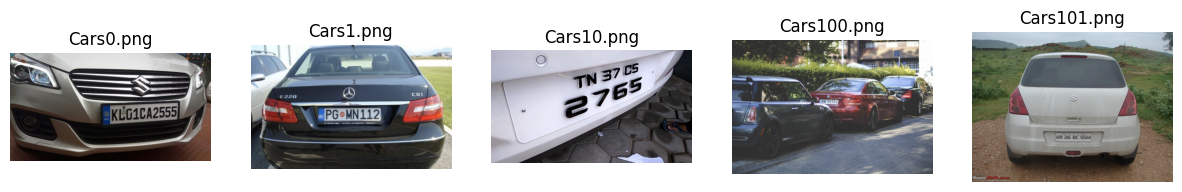

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

for i, (name, img) in enumerate(zip(filenames, images), 1):
    plt.subplot(1, 5, i)  # 1 صف و5 أعمدة، والصورة رقم i
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # عشان cv2 بترتب الألوان BGR، بنحولها لـ RGB
    plt.title(name)
    plt.axis('off')

plt.show()


In [14]:
import cv2
import numpy as np
import os

# دعم الصيغ المطلوبة
SUPPORTED_FORMATS = ('.jpg', '.png', '.tif')


In [15]:
def load_image(path: str) -> np.ndarray:
    """
    تحمل الصورة من المسار المحدد.
    - path: مسار الصورة.
    - تعيد: الصورة كـ numpy array.
    - ترمي استثناء في حالة عدم وجود الصورة أو صيغة غير مدعومة.
    """
    if not os.path.isfile(path):
        raise FileNotFoundError(f"ملف الصورة غير موجود: {path}")
    if not path.lower().endswith(SUPPORTED_FORMATS):
        raise ValueError(f"صيغة الملف غير مدعومة: {path}")
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"فشل في تحميل الصورة: {path}")
    return img


In [16]:
def adjust_brightness_contrast(img: np.ndarray, brightness=0, contrast=0) -> np.ndarray:
    """
    تعدل السطوع والتباين للصورة.
    - brightness: قيمة تتراوح من -100 إلى 100.
    - contrast: قيمة تتراوح من -100 إلى 100.
    - تعيد الصورة بعد التعديل.
    """
    beta = brightness
    alpha = 1 + (contrast / 100.0)  # مثال: 20% زيادة تعني alpha = 1.2
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted


In [17]:
def apply_gaussian_blur(img: np.ndarray, kernel_size=(5,5)) -> np.ndarray:
    """
    تطبق Gaussian Blur على الصورة لتقليل التفاصيل.
    - kernel_size: حجم النواة، يجب أن تكون أعداد فردية.
    - تعيد الصورة المفلترة.
    """
    blurred = cv2.GaussianBlur(img, kernel_size, 0)
    return blurred


In [18]:
def detect_edges(img: np.ndarray, low_threshold=100, high_threshold=200) -> np.ndarray:
    """
    تطبق كشف الحواف باستخدام خوارزمية Canny.
    - low_threshold و high_threshold: حدود الكشف.
    - تعيد صورة ثنائية تظهر الحواف.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges


In [19]:
def denoise_image(img: np.ndarray) -> np.ndarray:
    """
    تطبق تقليل التشويش باستخدام Non-local Means Denoising.
    - تعيد الصورة بعد التنقية.
    """
    denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    return denoised


In [20]:
def extract_features(img: np.ndarray, max_corners=100) -> np.ndarray:
    """
    تستخرج ميزات (نقاط زوايا) باستخدام طريقة Shi-Tomasi.
    - تعيد مصفوفة النقاط.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, max_corners, 0.01, 10)
    if corners is not None:
        corners = np.int0(corners)
    return corners


In [21]:
def save_image(img: np.ndarray, output_dir: str, filename: str):
    """
    تحفظ الصورة في المجلد المحدد مع اسم الملف.
    - يتأكد من وجود المجلد أو ينشئه.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, img)


In [ ]:
def main():
    input_path = r"C:\Users\user\Downloads\archive\images\Cars0.png"  # غير المسار حسب الصورة
    output_dir = "processed_images"
    
    try:
        img = load_image(input_path)
        
        bright_img = adjust_brightness_contrast(img, brightness=30, contrast=30)
        save_image(bright_img, output_dir, "brightness_contrast.png")
        
        blurred_img = apply_gaussian_blur(bright_img)
        save_image(blurred_img, output_dir, "gaussian_blur.png")
        
        denoised_img = denoise_image(blurred_img)
        save_image(denoised_img, output_dir, "denoised.png")
        
        edges_img = detect_edges(denoised_img)
        save_image(edges_img, output_dir, "edges.png")
        
        features = extract_features(denoised_img)
        if features is not None:
            for corner in features:
                x, y = corner.ravel()
                cv2.circle(denoised_img, (x, y), 5, (0, 255, 0), -1)
            save_image(denoised_img, output_dir, "features.png")
        print("there is no  photo to edit")
        
    except Exception as e:
        print(f"حدث خطأ أثناء المعالجة: {e}")

if __name__ == "__main__":
    main()


حدث خطأ أثناء المعالجة: module 'numpy' has no attribute 'int0'


In [23]:
import cv2
import numpy as np
import os

# تحميل الصورة
def load_image(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"ملف الصورة غير موجود: {path}")
    img = cv2.imread(path)
    if img is None:
        raise ValueError("فشل تحميل الصورة!")
    return img

# حفظ الصورة
def save_image(img, output_dir, filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    cv2.imwrite(os.path.join(output_dir, filename), img)

# تعديل السطوع والتباين
def adjust_brightness_contrast(img, brightness=0, contrast=0):
    return cv2.convertScaleAbs(img, alpha=1 + contrast / 100, beta=brightness)

# تطبيق Gaussian Blur
def apply_gaussian_blur(img, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(img, kernel_size, sigma)

# إزالة الضوضاء باستخدام Non-local Means
def denoise_image(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

# كشف الحواف باستخدام Canny
def detect_edges(img, threshold1=100, threshold2=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, threshold1, threshold2)

# استخراج المعالم (ركائز الزوايا)
def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=50, qualityLevel=0.01, minDistance=10)
    if corners is not None:
        corners = corners.astype(np.int32)
    return corners


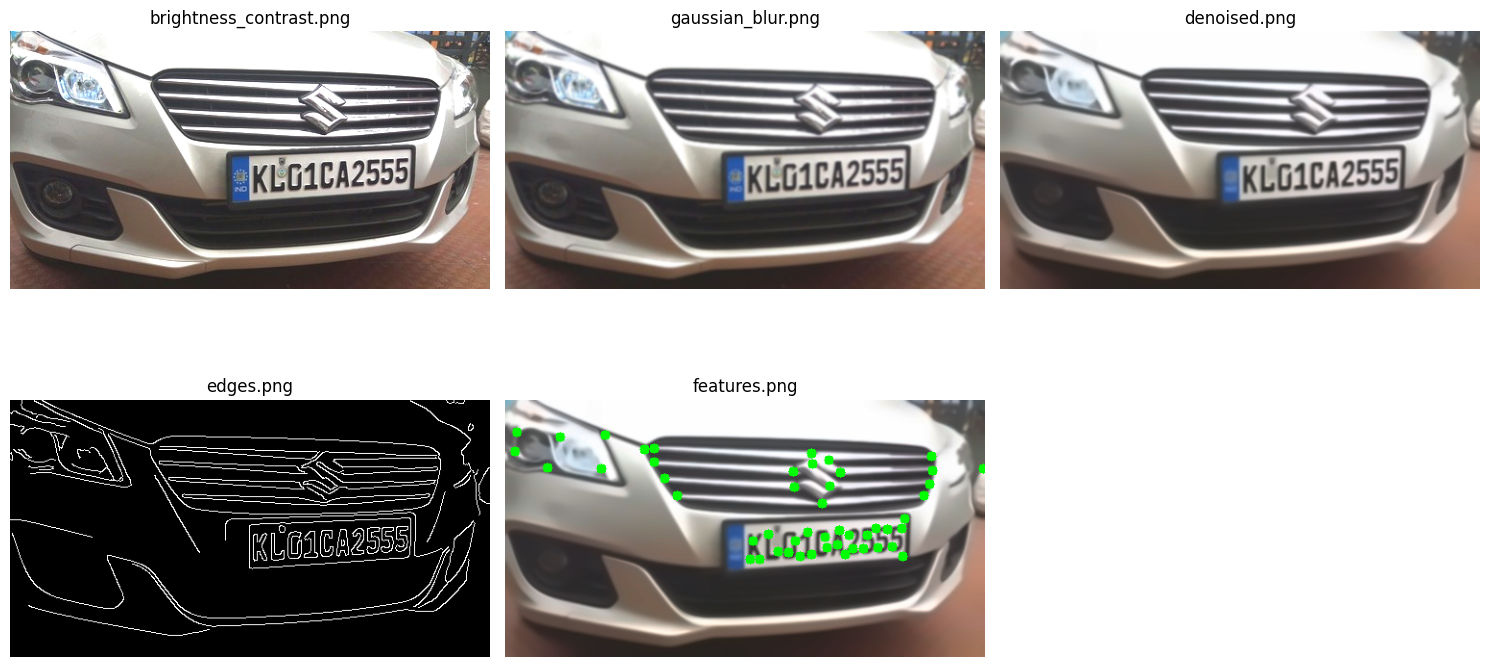

In [25]:
import cv2
import matplotlib.pyplot as plt
import os

# المسار إلى مجلد الصور المعالجة
output_dir = "processed_images"

# أسماء الصور المعالجة
image_files = [
    "brightness_contrast.png",
    "gaussian_blur.png",
    "denoised.png",
    "edges.png",
    "features.png"
]

# عدد الصور
num_images = len(image_files)

# إعداد الشكل
plt.figure(figsize=(15, 8))

# تحميل الصور وعرضها
for i, filename in enumerate(image_files, 1):
    path = os.path.join(output_dir, filename)
    img = cv2.imread(path)

    if img is not None:
        # لو الصورة grayscale (edges)، حولها عشان تتعرض صح
        if len(img.shape) == 2:
            img_display = img
            cmap = 'gray'
        else:
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cmap = None

        plt.subplot(2, 3, i)
        plt.imshow(img_display, cmap=cmap)
        plt.title(filename)
        plt.axis('off')
    else:
        print(f"❌ الصورة غير موجودة: {filename}")

plt.tight_layout()
plt.show()


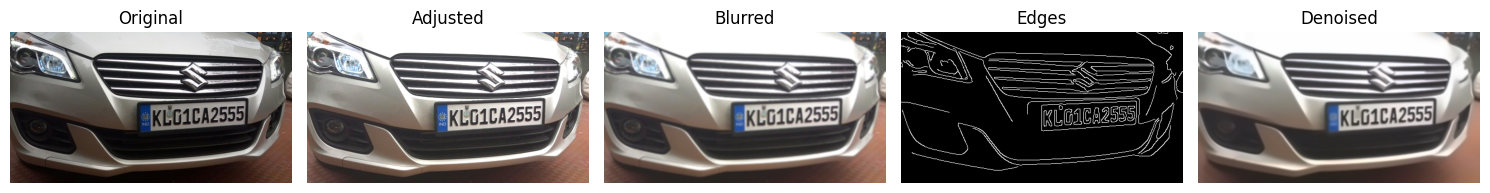

In [26]:
import cv2
import matplotlib.pyplot as plt
import os

# المسار إلى مجلد الصور المعالجة
output_dir = "processed_images"

# أسماء الملفات حسب الترتيب
image_files = [
    "brightness_contrast.png",  # Adjusted
    "gaussian_blur.png",        # Blurred
    "edges.png",                # Edges
    "denoised.png",             # Denoised
    "features.png"              # Optional (for visualization)
]

# العناوين
titles = ['Original', 'Adjusted', 'Blurred', 'Edges', 'Denoised']

# تحميل الصورة الأصلية
original_path = r"C:\Users\user\Downloads\archive\images\Cars0.png"  # غيّر الاسم حسب صورتك الأصلية
original_img = cv2.imread(original_path)

# إعداد الشكل
plt.figure(figsize=(15, 6))

# عرض الصورة الأصلية أولاً
if original_img is not None:
    img_display = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(img_display)
    plt.title(titles[0])
    plt.axis('off')
else:
    print("❌ الصورة الأصلية غير موجودة")

# عرض باقي الصور
for i, (filename, title) in enumerate(zip(image_files, titles[1:]), 2):
    path = os.path.join(output_dir, filename)
    img = cv2.imread(path)

    if img is not None:
        if len(img.shape) == 2:
            img_display = img
            cmap = 'gray'
        else:
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cmap = None

        plt.subplot(1, 5, i)
        plt.imshow(img_display, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    else:
        print(f"❌ الصورة غير موجودة: {filename}")

plt.tight_layout()
plt.show()


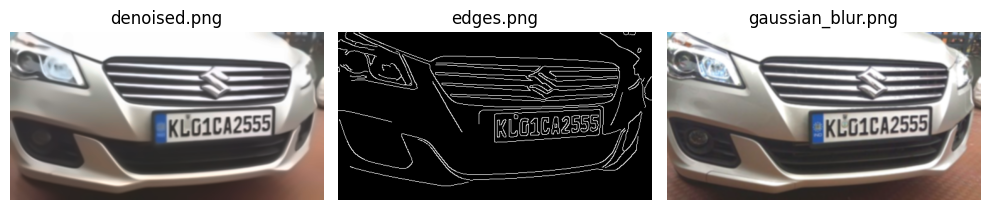

In [27]:
import os
import cv2
import random
import matplotlib.pyplot as plt

OUTPUT_DIR = "processed_images"

samples = random.sample(os.listdir(OUTPUT_DIR), 3)

plt.figure(figsize=(10, 4))
for i, filename in enumerate(samples):
    img_path = os.path.join(OUTPUT_DIR, filename)
    img = cv2.imread(img_path)
    plt.subplot(1, 3, i + 1)
    # لو اسم الملف فيه 'denoised' نعرض الصورة ألوان، غير كده صورة رمادية
    if 'denoised' in filename or filename.endswith(('.png', '.jpg', '.jpeg')):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')
plt.tight_layout()
plt.show()


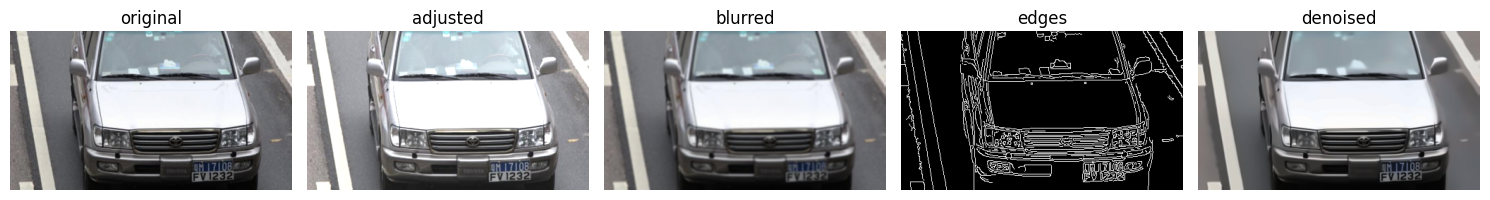

In [28]:
import cv2
import matplotlib.pyplot as plt

def process_sample_image(image_path):
    """Process a sample image and return results"""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"ملف الصورة غير موجود: {image_path}")
    
    results = {
        'original': img,
        'adjusted': cv2.convertScaleAbs(img, alpha=1.2, beta=20),
        'blurred': cv2.GaussianBlur(img, (5,5), 0),
        'edges': cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 50, 150),
        'denoised': cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    }
    return results

def create_collage(images_dict):
    """عرض الصور جنب بعض مع عنوان لكل صورة"""
    titles = list(images_dict.keys())
    images = list(images_dict.values())
    
    plt.figure(figsize=(15,5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        if titles[i] == 'edges':
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    image_path = r"C:\Users\user\Downloads\archive\images\Cars26.png"  # غير المسار لمسار صورتك عندك
    results = process_sample_image(image_path)
    create_collage(results)


In [41]:
import cv2
import numpy as np
import os

def load_image(file_path):
    """
    تحميل الصورة من المسار مع التحقق من الصيغة.
    يدعم jpg, png, tif.
    Raises FileNotFoundError, ValueError.
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"الصورة غير موجودة: {file_path}")
    
    ext = os.path.splitext(file_path)[1].lower()
    if ext not in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
        raise ValueError(f"نوع الملف غير مدعوم: {ext}")
    
    img = cv2.imread(file_path)
    if img is None:
        raise IOError("فشل تحميل الصورة (قد تكون تالفة).")
    return img

def save_image(img, output_dir, filename):
    """
    حفظ الصورة في المجلد المحدد مع إنشاء المجلد إذا لم يكن موجودًا.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    path = os.path.join(output_dir, filename)
    cv2.imwrite(path, img)
    print(f"📸 تم حفظ الصورة: {path}")

def adjust_brightness_contrast(img, brightness=0, contrast=0):
    """
    تعديل السطوع والتباين.
    brightness: -100 إلى 100
    contrast: -100 إلى 100
    """
    beta = brightness
    alpha = 1 + (contrast / 100.0)
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted

def apply_gaussian_blur(img, kernel_size=(5,5), sigma=0):
    """
    تطبيق Gaussian Blur لتقليل التفاصيل والتشويش.
    """
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    return blurred

def detect_edges(img, low_threshold=50, high_threshold=150):
    """
    كشف الحواف باستخدام خوارزمية Canny.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

def denoise_image(img, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21):
    """
    إزالة التشويش باستخدام Non-local Means Denoising.
    """
    denoised = cv2.fastNlMeansDenoisingColored(img, None, h, hColor, templateWindowSize, searchWindowSize)
    return denoised

def extract_features(img, max_corners=100, quality_level=0.01, min_distance=10):
    """
    استخراج نقاط ميزات (corners) باستخدام Shi-Tomasi Corner Detection.
    يعيد قائمة من النقاط.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, max_corners, quality_level, min_distance)
    if corners is not None:
        corners = np.int0(corners)
    return corners


In [ ]:
import cv2  # Import OpenCV library for image processing
import numpy as np  # Import NumPy for array operations
import os  # Import os for file and directory handling
from skimage.feature import hog  # Import HOG feature extractor
from skimage import color  # Import color module from skimage (not used here but imported)

def load_image(path):
    try:
        if not os.path.isfile(path):
            raise FileNotFoundError(f"File not found: {path}")  # Check if file exists
        ext = os.path.splitext(path)[1].lower()  # Get file extension
        if ext not in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
            raise ValueError("Unsupported file type. Use jpg, png or tif.")  # Validate extension
        img = cv2.imread(path)  # Read image using OpenCV
        if img is None:
            raise ValueError("Failed to load image - file may be corrupted.")  # Check if image loaded successfully
        return img  # Return loaded image
    except Exception as e:
        print(f"[load_image] {e}")  # Print error message if exception occurs
        return None  # Return None on failure

def save_image(img, output_dir, filename):
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)  # Create output directory if it doesn't exist
        path = os.path.join(output_dir, filename)  # Construct full save path
        cv2.imwrite(path, img)  # Save image to disk
        print(f"Image saved: {path}")  # Confirm saving image
    except Exception as e:
        print(f"[save_image] Error: {e}")  # Print error if saving fails

def adjust_brightness_contrast(img, brightness=0, contrast=0):
    try:
        beta = brightness  # Set brightness level
        alpha = 1 + (contrast / 100.0)  # Calculate contrast scale factor
        adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)  # Apply brightness and contrast
        return adjusted  # Return adjusted image
    except Exception as e:
        print(f"[adjust_brightness_contrast] Error: {e}")  # Error handling
        return img  # Return original image on failure

def apply_gaussian_blur(img, kernel_size=(5,5)):
    try:
        blurred = cv2.GaussianBlur(img, kernel_size, 0)  # Apply Gaussian blur with given kernel
        return blurred  # Return blurred image
    except Exception as e:
        print(f"[apply_gaussian_blur] Error: {e}")  # Error handling
        return img  # Return original image on failure

def denoise_image(img):
    try:
        denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)  # Apply color denoising
        return denoised  # Return denoised image
    except Exception as e:
        print(f"[denoise_image] Error: {e}")  # Error handling
        return img  # Return original image on failure

def detect_edges(img):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
        edges = cv2.Canny(gray, 100, 200)  # Detect edges using Canny algorithm
        return edges  # Return edge map
    except Exception as e:
        print(f"[detect_edges] Error: {e}")  # Error handling
        return img  # Return original image on failure

def extract_features(img):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        gray = np.float32(gray)  # Convert to float32 for Harris detector
        dst = cv2.cornerHarris(gray, 2, 3, 0.04)  # Detect corners using Harris algorithm
        dst = cv2.dilate(dst, None)  # Dilate corner points to enhance
        img_with_corners = img.copy()  # Copy original image to draw corners
        img_with_corners[dst > 0.01 * dst.max()] = [0, 0, 255]  # Mark corners in red
        return img_with_corners  # Return image with corners marked
    except Exception as e:
        print(f"[extract_features] Error: {e}")  # Error handling
        return img  # Return original image on failure

def extract_classification_features(img):
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')  # Extract HOG features
        return features, hog_image  # Return feature vector and visualization image
    except Exception as e:
        print(f"[extract_classification_features] Error: {e}")  # Error handling
        return [], img  # Return empty features and original image on failure

def main():
    input_path = r"C:\Users\user\Downloads\archive\images\Cars2.png"  # Set input image path
    output_dir = r"C:\Users\user\Downloads\archive\processed_images"  # Set output directory path

    img = load_image(input_path)  # Load image
    if img is None:
        print("Processing stopped: unable to load image.")  # Stop if load failed
        return

    bright_img = adjust_brightness_contrast(img, brightness=30, contrast=30)  # Adjust brightness and contrast
    save_image(bright_img, output_dir, "brightness_contrast.png")  # Save adjusted image

    blurred_img = apply_gaussian_blur(bright_img)  # Apply Gaussian blur
    save_image(blurred_img, output_dir, "gaussian_blur.png")  # Save blurred image

    denoised_img = denoise_image(blurred_img)  # Apply denoising
    save_image(denoised_img, output_dir, "denoised.png")  # Save denoised image

    edges_img = detect_edges(denoised_img)  # Detect edges
    save_image(edges_img, output_dir, "edges.png")  # Save edges image

    features_img = extract_features(denoised_img)  # Extract corners/features
    save_image(features_img, output_dir, "features.png")  # Save image with features

    features_vector, hog_vis = extract_classification_features(denoised_img)  # Extract HOG features
    if len(features_vector) > 0:
        save_image((hog_vis * 255).astype("uint8"), output_dir, "hog_features.png")  # Save HOG visualization
        print(f"Number of classification features: {len(features_vector)}")  # Print feature count
    else:
        print("Warning: No HOG features extracted.")  # Warn if no features extracted

    print("Processing completed successfully.")  # Processing complete message

if __name__ == "__main__":
    main()  # Run main function

Image saved: C:\Users\user\Downloads\archive\processed_images\brightness_contrast.png
Image saved: C:\Users\user\Downloads\archive\processed_images\gaussian_blur.png
Image saved: C:\Users\user\Downloads\archive\processed_images\denoised.png
Image saved: C:\Users\user\Downloads\archive\processed_images\edges.png
Image saved: C:\Users\user\Downloads\archive\processed_images\features.png
Image saved: C:\Users\user\Downloads\archive\processed_images\hog_features.png
Number of classification features: 86436
Processing completed successfully.


In [61]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
from PIL import Image, ImageTk
import cv2
import numpy as np
import os
from skimage.feature import hog

# معالجة الصور
def load_image(path):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    ext = os.path.splitext(path)[1].lower()
    if ext not in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
        raise ValueError("Unsupported file type.")
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Failed to load image.")
    return img

def adjust_brightness_contrast(img, brightness=30, contrast=30):
    beta = brightness
    alpha = 1 + (contrast / 100.0)
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def apply_gaussian_blur(img):
    return cv2.GaussianBlur(img, (5,5), 0)

def denoise_image(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

def detect_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, 100, 200)

def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    img_with_corners = img.copy()
    img_with_corners[dst > 0.01 * dst.max()] = [0, 0, 255]
    return img_with_corners

def extract_classification_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    return features, hog_image


class ImageApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Processing GUI")
        self.root.geometry("1000x600")
        self.root.configure(bg="#f0f0f0")

        self.img = None
        self.tk_img = None

        title = tk.Label(root, text="Image Processing App", font=("Helvetica", 18, "bold"), bg="#f0f0f0")
        title.pack(pady=10)

        top_frame = tk.Frame(root, bg="#f0f0f0")
        top_frame.pack(pady=10)

        btn_frame = tk.Frame(top_frame, bg="#f0f0f0")
        btn_frame.pack(side=tk.LEFT, padx=10)

        self.btn_load = ttk.Button(btn_frame, text="Load Image", command=self.load_image)
        self.btn_load.pack(pady=5)

        # checkboxes
        self.var_bright = tk.IntVar()
        self.var_blur = tk.IntVar()
        self.var_denoise = tk.IntVar()
        self.var_edges = tk.IntVar()
        self.var_features = tk.IntVar()
        self.var_hog = tk.IntVar()

        tk.Checkbutton(btn_frame, text="Brightness/Contrast", variable=self.var_bright, bg="#f0f0f0").pack(anchor="w")
        tk.Checkbutton(btn_frame, text="Gaussian Blur", variable=self.var_blur, bg="#f0f0f0").pack(anchor="w")
        tk.Checkbutton(btn_frame, text="Denoise", variable=self.var_denoise, bg="#f0f0f0").pack(anchor="w")
        tk.Checkbutton(btn_frame, text="Detect Edges", variable=self.var_edges, bg="#f0f0f0").pack(anchor="w")
        tk.Checkbutton(btn_frame, text="Extract Features", variable=self.var_features, bg="#f0f0f0").pack(anchor="w")
        tk.Checkbutton(btn_frame, text="Extract HOG Features", variable=self.var_hog, bg="#f0f0f0").pack(anchor="w")

        self.btn_process = ttk.Button(btn_frame, text="Process Image", command=self.process_image)
        self.btn_process.pack(pady=10)

        # canvas لعرض الصورة
        self.canvas = tk.Canvas(top_frame, width=600, height=500, bg="white", bd=2, relief=tk.RIDGE)
        self.canvas.pack(side=tk.RIGHT, padx=10)

    def load_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png *.tif *.tiff")])
        if file_path:
            try:
                self.img = load_image(file_path)
                self.show_image(self.img)
            except Exception as e:
                messagebox.showerror("Error", str(e))

    def show_image(self, img):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_pil = img_pil.resize((600, 500))
        self.tk_img = ImageTk.PhotoImage(img_pil)
        self.canvas.create_image(0, 0, anchor="nw", image=self.tk_img)

    def process_image(self):
        if self.img is None:
            messagebox.showwarning("Warning", "Please load an image first!")
            return

        img = self.img.copy()
        if self.var_bright.get():
            img = adjust_brightness_contrast(img)
        if self.var_blur.get():
            img = apply_gaussian_blur(img)
        if self.var_denoise.get():
            img = denoise_image(img)
        if self.var_edges.get():
            img = detect_edges(img)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if self.var_features.get():
            img = extract_features(img)
        if self.var_hog.get():
            features, hog_vis = extract_classification_features(img)
            img = (hog_vis * 255).astype("uint8")
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        self.show_image(img)
        messagebox.showinfo("Done", "Processing completed!")

if __name__ == "__main__":
    root = tk.Tk()
    app = ImageApp(root)
    root.mainloop()
